<a href="https://colab.research.google.com/github/ravi-gopalan/DAND_Data_Wrangling/blob/master/scrape_coc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install upgrade chromedriver

In [1]:
# install chromium, its driver
!apt-get update
!apt install chromium-chromedriver


Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [74.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:12 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:14 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic/main Sour

In [2]:
# install selenium

!pip install selenium

     |████████████████████████████████| 911kB 2.8MB/s 


# Library Imports

In [3]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

import nltk
import string
nltk.download(['stopwords','punkt','wordnet','averaged_perceptron_tagger','vader_lexicon'])
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer


from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# Chrome Webdriver

In [4]:
%time
# set options to be headless, ..


options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
# open it, go to a website, and get results
driver = webdriver.Chrome('chromedriver',options=options)



CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


In [0]:
%timeit
# Selenium script to scroll to the bottom, wait 3 seconds for the next batch of data to load, then continue scrolling.  
# It will continue to do this until the page stops loading new data.
url = 'https://play.google.com/store/apps/details?id=com.supercell.clashofclans&showAllReviews=true'
driver.get(url)
actions = webdriver.ActionChains(driver)

In [0]:
lenOfPage = driver.execute_script("window.scrollTo(0, document.body.scrollHeight); var lenOfPage=document.body.scrollHeight; return lenOfPage;")
match=False
while(match==False):
  lastCount = lenOfPage
  time.sleep(10)
  lenOfPage = driver.execute_script("window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return lenOfPage;")
  if lastCount==lenOfPage:
    match=True

In [7]:
lenOfPage

36130

In [8]:
show_more = driver.find_element(by='xpath',value="//div[@class='U26fgb O0WRkf oG5Srb C0oVfc n9lfJ']")
show_more.location


{'x': 563, 'y': 35453}

In [0]:
actions.move_to_element(show_more).click_and_hold(show_more).perform()

In [0]:
lenOfPage = driver.execute_script("window.scrollTo(0, document.body.scrollHeight); var lenOfPage=document.body.scrollHeight; return lenOfPage;")
match=False
while(match==False):
  lastCount = lenOfPage
  time.sleep(10)
  lenOfPage = driver.execute_script("window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return lenOfPage;")
  if lastCount==lenOfPage:
    match=True

In [11]:
lenOfPage

36130

In [12]:
driver.current_url

'https://play.google.com/store/apps/details?id=com.supercell.clashofclans&showAllReviews=true'

In [0]:
actions.move_to_element(show_more).click_and_hold(show_more).perform()

In [0]:
for i in range(10):
  time.sleep(2)
  actions.move_to_element(show_more).click_and_hold(show_more).perform()
  time.sleep(2)
  i += 1

In [17]:
bu = driver.find_elements(by='xpath',value="//div[@class='cQj82c']//button")
len(bu)

165

In [0]:
for item in bu:
  time.sleep(5)
  try:
    item.click()
  except:
    time.sleep(5)


In [88]:
bu1 = driver.find_elements_by_css_selector('button.RveJvd.snByac')


len(bu1)

0

In [21]:
driver.current_url

'https://play.google.com/store/apps/details?id=com.supercell.clashofclans&showAllReviews=true'

# Scrape reviews

In [22]:
reviewer = []
review_date = []
i = 0

review_info = {}
for item in driver.find_elements_by_css_selector('div.bAhLNe.kx8XBd'):
  reviewer.append(item.text)

helpful_reviews = driver.find_elements_by_css_selector('div.jUL89d.y92BAb')
abridged_review = driver.find_elements(by='xpath',value="//span[@jsname='bN97Pc']")
full_reviews  = driver.find_elements(by='xpath',value="//span[@jsname='fbQN7e']")
stars = driver.find_elements(by='xpath',value="//span[@class='nt2C1d']//div//div[@role='img']")
print(len(reviewer),len(abridged_review), len(full_reviews), len(helpful_reviews),len(stars))

200 200 200 200 200


In [28]:
print(abridged_review[5].text)
print(full_reviews[5].text)


Just upgraded to Town Hall 12 after maxing Town Hall 11. Walls are difficult to upgrade, but it can be done. Don't expect to download this game and become a pro right away. It takes a great amount of time, but the upgrade times are better than they were 5 years ago. Unfortunate that Global Chat had to go because I miss it so much, but they had their reasons. Great Game.


In [0]:

all_reviews = []
for i, (r, a, f, h, s) in enumerate(zip(reviewer, abridged_review,full_reviews, helpful_reviews, stars )):
  review_info = {}
  review_info.update({'id':i, \
                      'name':r.split('\n')[0], \
                      'review_date':r.split('\n')[1], \
                      'abridged_review': a.text, \
                      'full_review': f.text, \
                      'helpful_review': h.text, \
                      'stars':re.findall(r"\d",s.get_attribute('aria-label'))[0]})
  all_reviews.append(review_info)


In [30]:
df_review = pd.DataFrame(all_reviews)
df_review.head()

,id,name,review_date,abridged_review,full_review,helpful_review,stars
0,0,Beast Stocker21,"November 10, 2019","Genuinely, Strategy is the key factor of this ...",,951,4
1,1,jonathan biscuit,"November 11, 2019",,I would have gave this 5 stars but their are t...,71,3
2,2,Jeffrey Bach,"November 11, 2019",,Still an amazing game after all these years. I...,63,3
3,3,Kritik Agrawal,"October 27, 2019",,"Great game, can keep you hooked on for hours (...",299,4
4,4,v_Vo1tage,"October 29, 2019",,I had this game for a very long time all these...,182,5


In [31]:
df_review.tail()

,id,name,review_date,abridged_review,full_review,helpful_review,stars
195,195,THDevil,"November 9, 2019",,"Amazing game, Great Quality, it's like a tycoo...",19,5
196,196,Vaudev Charan,"October 24, 2019",,I really like this game but i like the most is...,1,5
197,197,Kyle Junzel Banaria,"October 22, 2019",,What's on your mind Supercell developers? What...,45,1
198,198,քʀɨռċɛօʍɢ քʟaʏs aռɖ ʋʟօɢ,"October 30, 2019",,I am playing this and this is so fun but i thi...,63,1
199,199,The RookieGamer,"October 26, 2019",This game was a lot better before they took aw...,,15,3


In [32]:
df_review['full_review'] = [''.join([str(x), str(y)]) for x, y in zip(df_review['full_review'], df_review['abridged_review'])]
df_review.head()

,id,name,review_date,abridged_review,full_review,helpful_review,stars
0,0,Beast Stocker21,"November 10, 2019","Genuinely, Strategy is the key factor of this ...","Genuinely, Strategy is the key factor of this ...",951,4
1,1,jonathan biscuit,"November 11, 2019",,I would have gave this 5 stars but their are t...,71,3
2,2,Jeffrey Bach,"November 11, 2019",,Still an amazing game after all these years. I...,63,3
3,3,Kritik Agrawal,"October 27, 2019",,"Great game, can keep you hooked on for hours (...",299,4
4,4,v_Vo1tage,"October 29, 2019",,I had this game for a very long time all these...,182,5


In [33]:
df_review.tail()

,id,name,review_date,abridged_review,full_review,helpful_review,stars
195,195,THDevil,"November 9, 2019",,"Amazing game, Great Quality, it's like a tycoo...",19,5
196,196,Vaudev Charan,"October 24, 2019",,I really like this game but i like the most is...,1,5
197,197,Kyle Junzel Banaria,"October 22, 2019",,What's on your mind Supercell developers? What...,45,1
198,198,քʀɨռċɛօʍɢ քʟaʏs aռɖ ʋʟօɢ,"October 30, 2019",,I am playing this and this is so fun but i thi...,63,1
199,199,The RookieGamer,"October 26, 2019",This game was a lot better before they took aw...,This game was a lot better before they took aw...,15,3


In [0]:
df_review.drop(columns=['abridged_review'],inplace=True)

In [35]:
df_review.info()
df_review.head()
df_review['review_date'] = df_review['review_date'].apply(lambda x: pd.datetime.strptime(x, '%B %d, %Y'))
df_review['helpful_review'] = pd.to_numeric(df_review['helpful_review'], errors='coerce')
df_review['stars'] = df_review['stars'].astype('int8') 
df_review.info()
df_review.head()

df_review.info()
df_review.head()
df_review.drop(columns=['id'],inplace=True)
df_review.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
id                200 non-null int64
name              200 non-null object
review_date       200 non-null object
full_review       200 non-null object
helpful_review    200 non-null object
stars             200 non-null object
dtypes: int64(1), object(5)
memory usage: 9.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
id                200 non-null int64
name              200 non-null object
review_date       200 non-null datetime64[ns]
full_review       200 non-null object
helpful_review    185 non-null float64
stars             200 non-null int8
dtypes: datetime64[ns](1), float64(1), int64(1), int8(1), object(2)
memory usage: 8.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
id                200 non-null int64
name              200 non-null object
review_date 

,name,review_date,full_review,helpful_review,stars
0,Beast Stocker21,2019-11-10,"Genuinely, Strategy is the key factor of this ...",951.0,4
1,jonathan biscuit,2019-11-11,I would have gave this 5 stars but their are t...,71.0,3
2,Jeffrey Bach,2019-11-11,Still an amazing game after all these years. I...,63.0,3
3,Kritik Agrawal,2019-10-27,"Great game, can keep you hooked on for hours (...",299.0,4
4,v_Vo1tage,2019-10-29,I had this game for a very long time all these...,182.0,5


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


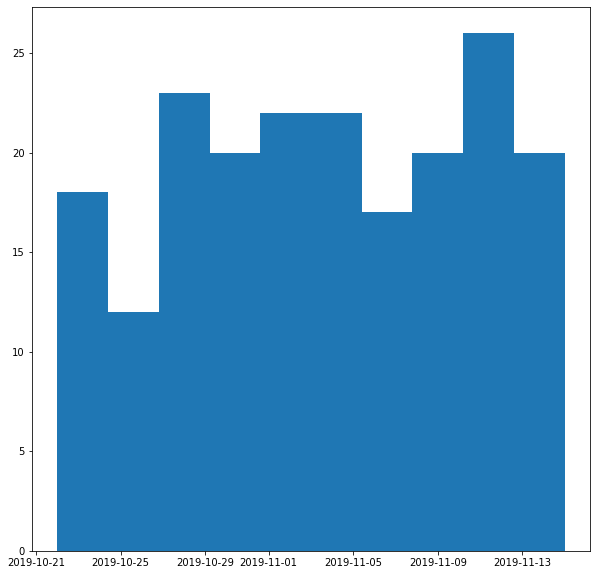

In [36]:
plt.figure(figsize=(10,10))
plt.hist(df_review['review_date'])
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


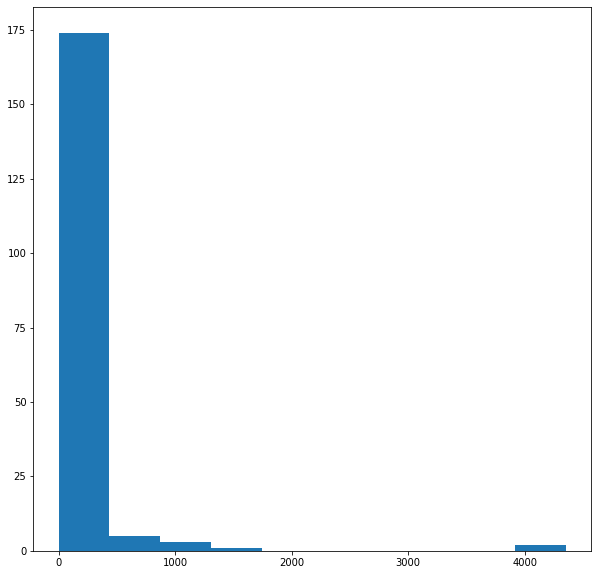

In [37]:
plt.figure(figsize=(10,10))
plt.hist(df_review['helpful_review'])
plt.show()

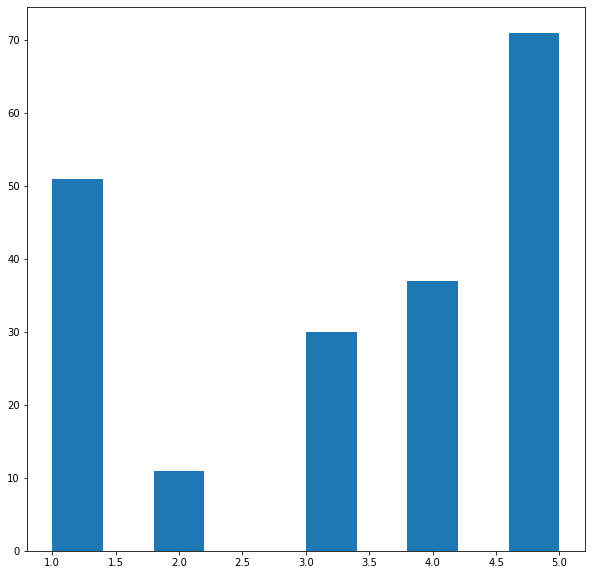

In [38]:
plt.figure(figsize=(10,10))
plt.hist(df_review['stars'])
plt.show()

# Combine Reviews and Responses

In [43]:
df_review.query('review_date > "2019-10-30"')

,name,review_date,full_review,helpful_review,stars
0,Beast Stocker21,2019-11-10,"Genuinely, Strategy is the key factor of this ...",951.0,4
1,jonathan biscuit,2019-11-11,I would have gave this 5 stars but their are t...,71.0,3
2,Jeffrey Bach,2019-11-11,Still an amazing game after all these years. I...,63.0,3
5,Colin Malecha,2019-11-05,Just upgraded to Town Hall 12 after maxing Tow...,87.0,5
6,abhishek shankar,2019-11-10,It's a humble request Please fix the connectio...,31.0,4
...,...,...,...,...,...
190,Amaan Tasneem,2019-11-03,Coc is really getting better and better thats ...,NaN,5
192,Robert Johnson,2019-11-12,I love the game it's one of the games I've alw...,10.0,5
193,Pawan Kumar,2019-11-04,"Hey Supercell, I've been playing this game sin...",NaN,5
194,shishir sharma,2019-11-02,Good game but coc is cheating its user I got r...,NaN,1


In [0]:
df_review_updated = df_review

In [45]:
df_review_updated.tail()


,name,review_date,full_review,helpful_review,stars
195,THDevil,2019-11-09,"Amazing game, Great Quality, it's like a tycoo...",19.0,5
196,Vaudev Charan,2019-10-24,I really like this game but i like the most is...,1.0,5
197,Kyle Junzel Banaria,2019-10-22,What's on your mind Supercell developers? What...,45.0,1
198,քʀɨռċɛօʍɢ քʟaʏs aռɖ ʋʟօɢ,2019-10-30,I am playing this and this is so fun but i thi...,63.0,1
199,The RookieGamer,2019-10-26,This game was a lot better before they took aw...,15.0,3


In [46]:
df_review_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
name              200 non-null object
review_date       200 non-null datetime64[ns]
full_review       200 non-null object
helpful_review    185 non-null float64
stars             200 non-null int8
dtypes: datetime64[ns](1), float64(1), int8(1), object(2)
memory usage: 6.6+ KB


In [0]:
df_review_updated['helpful_review'] = pd.to_numeric(df_review_updated['helpful_review'], errors='coerce')
df_review_updated['stars'] = df_review_updated['stars'].astype('int8') 

In [48]:
df_review_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
name              200 non-null object
review_date       200 non-null datetime64[ns]
full_review       200 non-null object
helpful_review    185 non-null float64
stars             200 non-null int8
dtypes: datetime64[ns](1), float64(1), int8(1), object(2)
memory usage: 6.6+ KB


In [49]:
df_review_updated.head()

,name,review_date,full_review,helpful_review,stars
0,Beast Stocker21,2019-11-10,"Genuinely, Strategy is the key factor of this ...",951.0,4
1,jonathan biscuit,2019-11-11,I would have gave this 5 stars but their are t...,71.0,3
2,Jeffrey Bach,2019-11-11,Still an amazing game after all these years. I...,63.0,3
3,Kritik Agrawal,2019-10-27,"Great game, can keep you hooked on for hours (...",299.0,4
4,v_Vo1tage,2019-10-29,I had this game for a very long time all these...,182.0,5


# NLP Analysis

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    # lower text
    try:
      text = str(text).lower()
    except:
      text = ''.join(re.findall(r"\D",str(text))).lower()


    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    #text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [0]:
df_review_updated['clean_reviews'] = df_review_updated['full_review'].apply(lambda x: clean_text(x))


In [53]:
df_review_updated.head()

,name,review_date,full_review,helpful_review,stars,clean_reviews
0,Beast Stocker21,2019-11-10,"Genuinely, Strategy is the key factor of this ...",951.0,4,genuinely strategy key factor particular game ...
1,jonathan biscuit,2019-11-11,I would have gave this 5 stars but their are t...,71.0,3,would gave stars two reasons first reason game...
2,Jeffrey Bach,2019-11-11,Still an amazing game after all these years. I...,63.0,3,"still amazing game years noticed it""s changed ..."
3,Kritik Agrawal,2019-10-27,"Great game, can keep you hooked on for hours (...",299.0,4,great game keep hooked hours read days go prog...
4,v_Vo1tage,2019-10-29,I had this game for a very long time all these...,182.0,5,game long time hate comments really true peopl...


In [54]:
df_review_updated.tail()

,name,review_date,full_review,helpful_review,stars,clean_reviews
195,THDevil,2019-11-09,"Amazing game, Great Quality, it's like a tycoo...",19.0,5,amazing game great quality like tycoon fight g...
196,Vaudev Charan,2019-10-24,I really like this game but i like the most is...,1.0,5,really like game like new feature use training...
197,Kyle Junzel Banaria,2019-10-22,What's on your mind Supercell developers? What...,45.0,1,what's mind supercell developers nonsense idea...
198,քʀɨռċɛօʍɢ քʟaʏs aռɖ ʋʟօɢ,2019-10-30,I am playing this and this is so fun but i thi...,63.0,1,playing fun think new update sucks there's glo...
199,The RookieGamer,2019-10-26,This game was a lot better before they took aw...,15.0,3,game lot better took away global made times ha...


In [55]:


df_review_updated.head(20)

,name,review_date,full_review,helpful_review,stars,clean_reviews
0,Beast Stocker21,2019-11-10,"Genuinely, Strategy is the key factor of this ...",951.0,4,genuinely strategy key factor particular game ...
1,jonathan biscuit,2019-11-11,I would have gave this 5 stars but their are t...,71.0,3,would gave stars two reasons first reason game...
2,Jeffrey Bach,2019-11-11,Still an amazing game after all these years. I...,63.0,3,"still amazing game years noticed it""s changed ..."
3,Kritik Agrawal,2019-10-27,"Great game, can keep you hooked on for hours (...",299.0,4,great game keep hooked hours read days go prog...
4,v_Vo1tage,2019-10-29,I had this game for a very long time all these...,182.0,5,game long time hate comments really true peopl...
5,Colin Malecha,2019-11-05,Just upgraded to Town Hall 12 after maxing Tow...,87.0,5,upgraded town hall maxing town hall walls diff...
6,abhishek shankar,2019-11-10,It's a humble request Please fix the connectio...,31.0,4,humble request please fix connection error iss...
7,Lara Sahay,2019-11-11,This game rewards patience. I enjoy checking o...,353.0,5,game rewards patience enjoy checking progress ...
8,Ubaidillah,2019-11-03,"I started playing this game in 2015, in mid-20...",346.0,5,started playing game stopped playing account b...
9,Steve Mueller,2019-10-31,Great game. Only the developers make sure that...,252.0,5,great game developers make sure purchasing stu...


# Sentiment Analysis

In [59]:
# add sentiment anaylsis columns
sid = SentimentIntensityAnalyzer()

df_sentiments = pd.DataFrame(list(df_review_updated['full_review'].apply(lambda x: sid.polarity_scores(x))))
df_sentiments.columns=['review_neg','review_neu','review_pos','review_compound']
df_sentiments.head()

,review_neg,review_neu,review_pos,review_compound
0,0.000,0.843,0.157,0.8268
1,0.078,0.873,0.050,-0.3224
2,0.000,0.743,0.257,0.9545
3,0.115,0.700,0.185,0.7858
4,0.069,0.839,0.093,0.2969


In [61]:
df_review_updated = pd.concat([df_review_updated, df_sentiments],axis=1)
df_review_updated.head()

,name,review_date,full_review,helpful_review,stars,clean_reviews,review_neg,review_neu,review_pos,review_compound
0,Beast Stocker21,2019-11-10,"Genuinely, Strategy is the key factor of this ...",951.0,4,genuinely strategy key factor particular game ...,0.000,0.843,0.157,0.8268
1,jonathan biscuit,2019-11-11,I would have gave this 5 stars but their are t...,71.0,3,would gave stars two reasons first reason game...,0.078,0.873,0.050,-0.3224
2,Jeffrey Bach,2019-11-11,Still an amazing game after all these years. I...,63.0,3,"still amazing game years noticed it""s changed ...",0.000,0.743,0.257,0.9545
3,Kritik Agrawal,2019-10-27,"Great game, can keep you hooked on for hours (...",299.0,4,great game keep hooked hours read days go prog...,0.115,0.700,0.185,0.7858
4,v_Vo1tage,2019-10-29,I had this game for a very long time all these...,182.0,5,game long time hate comments really true peopl...,0.069,0.839,0.093,0.2969


# TFIDF

In [62]:
df_review_updated.review_compound.mean()
df_review_updated.stars.mean()

3.33

In [65]:
# add tf-idfs columns

tfidf = TfidfVectorizer(min_df=5)
tfidf_result = tfidf.fit_transform(df_review_updated['clean_reviews']).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = df_review_updated.index
tfidf_df.head()

,word_able,word_account,word_accounts,word_across,word_active,word_actually,word_add,word_addictive,word_allow,word_already,word_also,word_always,word_amazing,word_amount,word_and,word_annoying,word_another,word_anymore,word_anything,word_apps,word_around,word_attack,word_attacked,word_attacking,word_attacks,word_away,word_awesome,word_back,word_bad,word_base,word_battle,word_became,word_become,word_best,word_better,word_big,word_bored,word_boring,word_bring,word_build,...,word_times,word_together,word_took,word_town,word_townhall,word_tried,word_troop,word_troops,word_trophies,word_try,word_two,word_unfair,word_update,word_updates,word_upgrade,word_upgraded,word_upgrades,word_upgrading,word_us,word_use,word_used,word_using,word_ve,word_village,word_wait,word_walls,word_want,word_war,word_wars,word_way,word_well,word_win,word_without,word_work,word_working,word_world,word_worth,word_would,word_year,word_years
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.379921,0.0,0.0,0.0,0.0,0.0,0.0,0.206582,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.379921,0.250199,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.202153,0.0,0.0,0.0,0.0,0.0,0.0,0.19294,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.202153,0.0,0.0,0.0,0.0,0.0,0.000000,0.213428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.220175,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.137428,0.0,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.164532,0.206602,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.173737,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.136046,0.0,0.0,0.000000,0.0,0.185172,0.0,0.0,0.0,0.0,0.0,0.128956,0.0,0.133082
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.228641,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.186248,0.0,0.238859,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
4,0.0,0.177194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.147348,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.123116,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.187615,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


In [66]:
tfidf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Columns: 297 entries, word_able to word_years
dtypes: float64(297)
memory usage: 464.2 KB


In [67]:
df_review_updated = pd.concat([df_review_updated, tfidf_df], axis=1)
df_review_updated.head(10)

,name,review_date,full_review,helpful_review,stars,clean_reviews,review_neg,review_neu,review_pos,review_compound,word_able,word_account,word_accounts,word_across,word_active,word_actually,word_add,word_addictive,word_allow,word_already,word_also,word_always,word_amazing,word_amount,word_and,word_annoying,word_another,word_anymore,word_anything,word_apps,word_around,word_attack,word_attacked,word_attacking,word_attacks,word_away,word_awesome,word_back,word_bad,word_base,...,word_times,word_together,word_took,word_town,word_townhall,word_tried,word_troop,word_troops,word_trophies,word_try,word_two,word_unfair,word_update,word_updates,word_upgrade,word_upgraded,word_upgrades,word_upgrading,word_us,word_use,word_used,word_using,word_ve,word_village,word_wait,word_walls,word_want,word_war,word_wars,word_way,word_well,word_win,word_without,word_work,word_working,word_world,word_worth,word_would,word_year,word_years
0,Beast Stocker21,2019-11-10,"Genuinely, Strategy is the key factor of this ...",951.0,4,genuinely strategy key factor particular game ...,0.000,0.843,0.157,0.8268,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.379921,0.000000,0.0,0.0,0.0,0.000000,0.0,0.206582,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.379921,0.250199,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,jonathan biscuit,2019-11-11,I would have gave this 5 stars but their are t...,71.0,3,would gave stars two reasons first reason game...,0.078,0.873,0.050,-0.3224,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.202153,0.0,...,0.000000,0.0,0.000000,0.202153,0.0,0.0,0.0,0.0,0.0,0.000000,0.213428,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.220175,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.137428,0.0,0.000000
2,Jeffrey Bach,2019-11-11,Still an amazing game after all these years. I...,63.0,3,"still amazing game years noticed it""s changed ...",0.000,0.743,0.257,0.9545,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.164532,0.206602,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.173737,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.136046,0.0,0.0,0.000000,0.0,0.185172,0.000000,0.0,0.0,0.0,0.0,0.128956,0.0,0.133082
3,Kritik Agrawal,2019-10-27,"Great game, can keep you hooked on for hours (...",299.0,4,great game keep hooked hours read days go prog...,0.115,0.700,0.185,0.7858,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.228641,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.186248,0.0,0.238859,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
4,v_Vo1tage,2019-10-29,I had this game for a very long time all these...,182.0,5,game long time hate comments really true peopl...,0.069,0.839,0.093,0.2969,0.0,0.177194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.147348,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.123116,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.187615,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
5,Colin Malecha,2019-11-05,Just upgraded to Town Hall 12 after maxing Tow...,87.0,5,upgraded town hall maxing town hall walls diff...,0.090,0.731,0.179,0.8885,

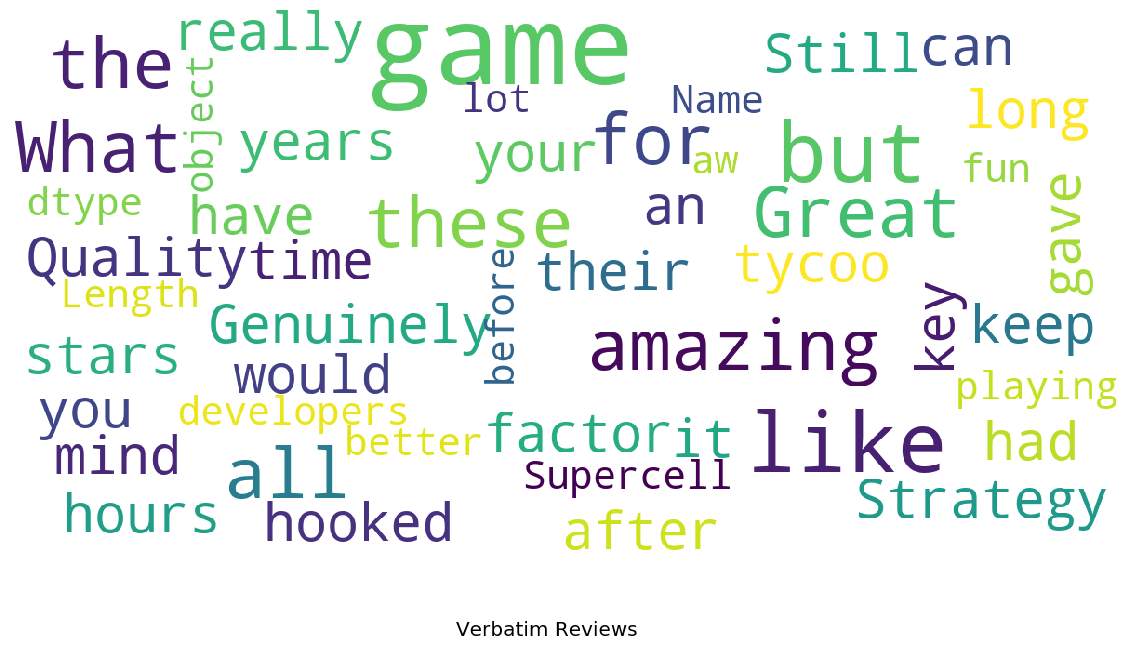

In [74]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, stop, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42,
        stopwords = stop
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    




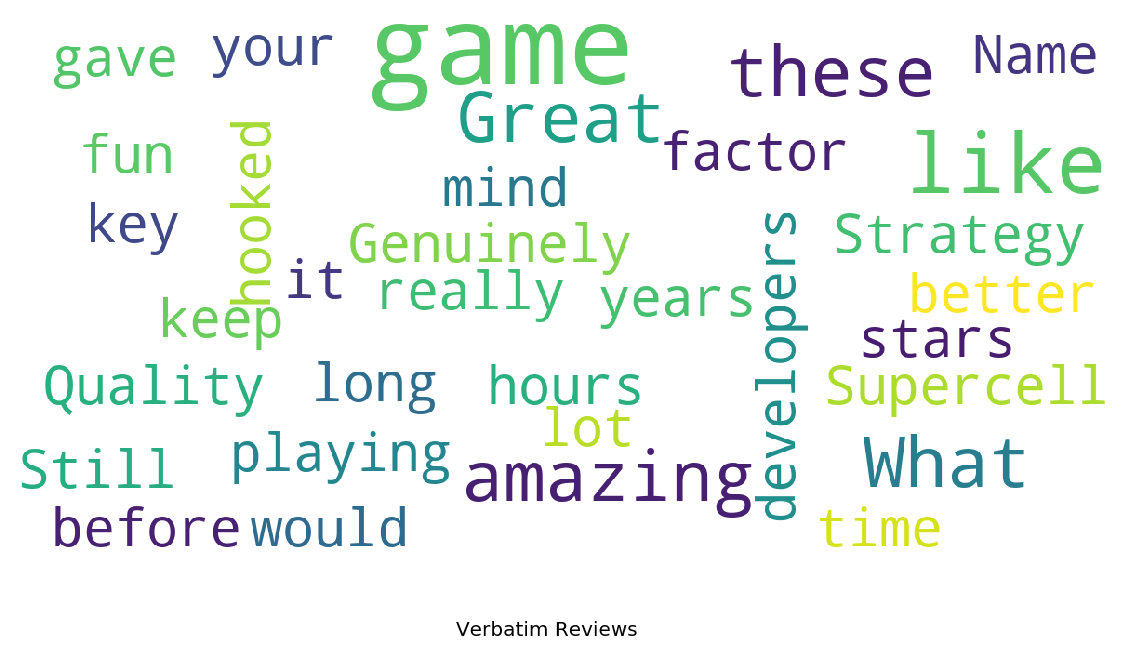

In [79]:
# print wordcloud
stop_words = {'it','am','very','is','and','this','full_review','of','on','so','thi','they','are','most','took',\
              'was','dtype','tycoo','can','had','after','the','you','their','for','an','aw','but','all','it','have','object','Length'}
show_wordcloud(df_review_updated['full_review'],stop_words,'Verbatim Reviews')

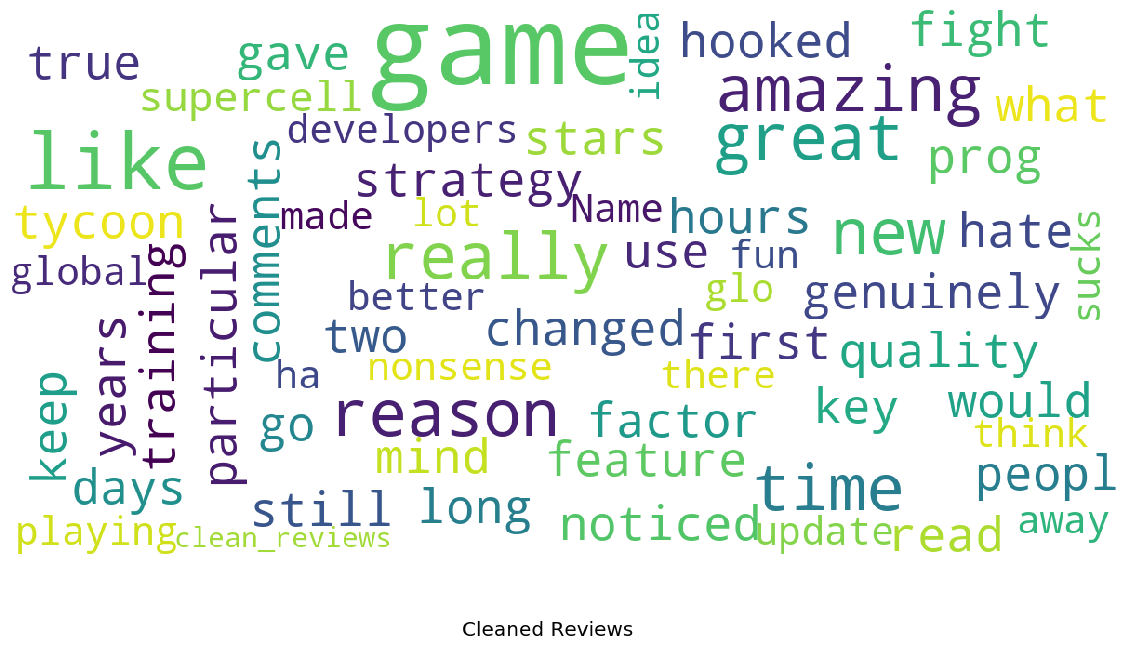

In [80]:
show_wordcloud(df_review_updated['clean_reviews'],stop_words,'Cleaned Reviews')

In [0]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Columns: 105 entries, name to word_years
dtypes: datetime64[ns](2), float64(97), int8(1), object(5)
memory usage: 162.8+ KB


In [0]:
df_review_updated['day'] = df_review_updated['review_date'].dt.day
df_review_updated['week'] = df_review_updated['review_date'].dt.week
df_review_updated['month'] = df_review_updated['review_date'].dt.month
df_review_updated['hour'] = df_review_updated['review_date'].dt.hour
df_review_updated['year'] = df_review_updated['review_date'].dt.year

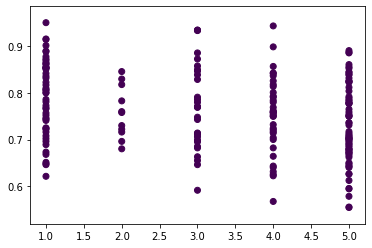

In [83]:
plt.scatter(df_review_updated['stars'],df_review_updated['review_neu'],c=df_review_updated['year'])

In [84]:
df_review_updated[['name','stars','review_compound','year','month']].sort_values(['review_compound'],ascending=False)

,name,stars,review_compound,year,month
92,Mrs. Manju Mishra,5,0.9932,2019,11
98,Jon Lionhart,5,0.9903,2019,11
37,jUaN PlayZ,5,0.9875,2019,11
142,karthik ganjam,5,0.9840,2019,11
158,Opal Green,5,0.9840,2019,10
...,...,...,...,...,...
113,A Google user,5,-0.9498,2019,11
130,Daniel E,3,-0.9554,2019,11
59,ben holmes,4,-0.9655,2019,11
150,7 STAR'S,1,-0.9677,2019,10


,year,month,stars,review_compond
0,2018,4,5.000000,0.759850
1,2018,5,5.000000,0.695260
2,2018,6,3.000000,0.844200
3,2018,7,5.000000,0.619650
4,2018,8,4.000000,0.480600
5,2018,9,4.833333,0.819783
6,2018,10,5.000000,0.935800
7,2018,11,5.000000,0.826650
8,2019,2,5.000000,0.555350
9,2019,3,4.000000,0.720450


In [85]:
star_analysis = df_review_updated[['name','stars','review_compound','year','month']].groupby(by=['year','month'], as_index=False)['stars','review_compound'].agg(np.mean)

star_analysis.head()

,year,month,stars,review_compound
0,2019,10,3.178082,0.294555
1,2019,11,3.417323,0.383850


In [86]:
star_analysis = star_analysis.assign(date=pd.to_datetime(star_analysis[['year', 'month']].assign(day=1)))

star_analysis.head()

,year,month,stars,review_compound,date
0,2019,10,3.178082,0.294555,2019-10-01
1,2019,11,3.417323,0.383850,2019-11-01


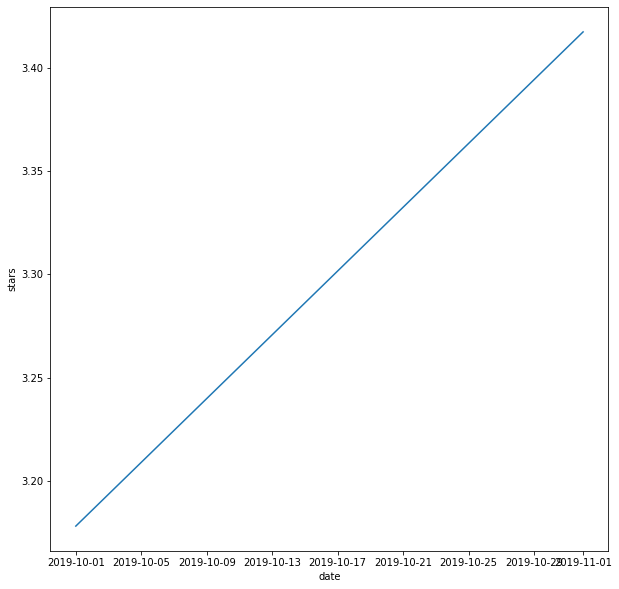

In [87]:
plt.figure(figsize=(10,10))
sns.lineplot(data=star_analysis,x = 'date', y = 'stars')

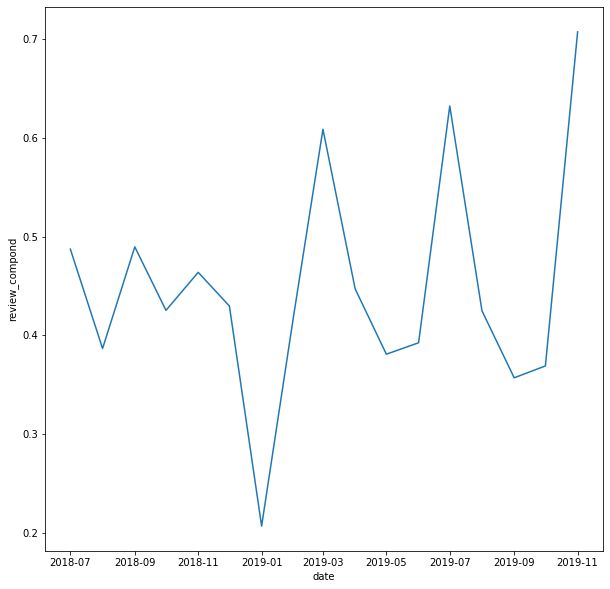

In [0]:
plt.figure(figsize=(10,10))
sns.lineplot(data=star_analysis,x = 'date', y = 'review_compond')

In [88]:
df_review_updated.query('year==2019 & month==11')

,name,review_date,full_review,helpful_review,stars,clean_reviews,review_neg,review_neu,review_pos,review_compound,word_able,word_account,word_accounts,word_across,word_active,word_actually,word_add,word_addictive,word_allow,word_already,word_also,word_always,word_amazing,word_amount,word_and,word_annoying,word_another,word_anymore,word_anything,word_apps,word_around,word_attack,word_attacked,word_attacking,word_attacks,word_away,word_awesome,word_back,word_bad,word_base,...,word_tried,word_troop,word_troops,word_trophies,word_try,word_two,word_unfair,word_update,word_updates,word_upgrade,word_upgraded,word_upgrades,word_upgrading,word_us,word_use,word_used,word_using,word_ve,word_village,word_wait,word_walls,word_want,word_war,word_wars,word_way,word_well,word_win,word_without,word_work,word_working,word_world,word_worth,word_would,word_year,word_years,day,week,month,hour,year
0,Beast Stocker21,2019-11-10,"Genuinely, Strategy is the key factor of this ...",951.0,4,genuinely strategy key factor particular game ...,0.000,0.843,0.157,0.8268,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.379921,0.000000,0.0,0.0,0.0,0.000000,0.0,0.206582,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.379921,0.250199,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,10,45,11,0,2019
1,jonathan biscuit,2019-11-11,I would have gave this 5 stars but their are t...,71.0,3,would gave stars two reasons first reason game...,0.078,0.873,0.050,-0.3224,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.202153,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.213428,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.220175,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.137428,0.0,0.000000,11,46,11,0,2019
2,Jeffrey Bach,2019-11-11,Still an amazing game after all these years. I...,63.0,3,"still amazing game years noticed it""s changed ...",0.000,0.743,0.257,0.9545,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.164532,0.206602,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.173737,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.136046,0.0,0.0,0.000000,0.0,0.185172,0.000000,0.0,0.0,0.0,0.0,0.128956,0.0,0.133082,11,46,11,0,2019
5,Colin Malecha,2019-11-05,Just upgraded to Town Hall 12 after maxing Tow...,87.0,5,upgraded town hall maxing town hall walls diff...,0.090,0.731,0.179,0.8885,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.211620,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.185443,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.292120,0.21162,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.205135,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.136314,5,45,11,0,2019
6,abhishek shankar,2019-11-10,It's a humble request Please fix the connectio...,31.0,4,humble request please fix connection error iss...,0.117,0.801,0.081,-0.3818,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.212176,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.220621,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.175341,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.204789,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,10,45,11,0,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [89]:
df_review_updated.query('year==2019 & month==11')[['name','full_review','stars','review_compound']]

,name,full_review,stars,review_compound
0,Beast Stocker21,"Genuinely, Strategy is the key factor of this ...",4,0.8268
1,jonathan biscuit,I would have gave this 5 stars but their are t...,3,-0.3224
2,Jeffrey Bach,Still an amazing game after all these years. I...,3,0.9545
5,Colin Malecha,Just upgraded to Town Hall 12 after maxing Tow...,5,0.8885
6,abhishek shankar,It's a humble request Please fix the connectio...,4,-0.3818
...,...,...,...,...
190,Amaan Tasneem,Coc is really getting better and better thats ...,5,0.8563
192,Robert Johnson,I love the game it's one of the games I've alw...,5,0.8057
193,Pawan Kumar,"Hey Supercell, I've been playing this game sin...",5,0.9621
194,shishir sharma,Good game but coc is cheating its user I got r...,1,-0.5859
